In [1]:
#library imports
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots, cm
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
import sklearn.model_selection as skm
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

In [2]:
from ISLP import load_data, confusion_table

from sklearn.svm import SVC
from ISLP.svm import plot as plot_svm
from sklearn.metrics import RocCurveDisplay
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

In [3]:
roc_curve = RocCurveDisplay.from_estimator # shorthand


In [4]:
#loading the csv file
pd.set_option('display.max_columns', None)
df=pd.read_csv("Housing.csv")
df.columns

Index(['SERIAL', 'DENSITY', 'OWNERSHP', 'OWNERSHPD', 'COSTELEC', 'COSTGAS',
       'COSTWATR', 'COSTFUEL', 'HHINCOME', 'ROOMS', 'BUILTYR2', 'BEDROOMS',
       'VEHICLES', 'NFAMS', 'NCOUPLES', 'PERNUM', 'PERWT', 'AGE', 'MARST',
       'BIRTHYR', 'EDUC', 'EDUCD', 'INCTOT'],
      dtype='object')

In [5]:
df.shape

(75388, 23)

In [6]:
df.head()

,SERIAL,DENSITY,OWNERSHP,OWNERSHPD,COSTELEC,COSTGAS,COSTWATR,COSTFUEL,HHINCOME,ROOMS,BUILTYR2,BEDROOMS,VEHICLES,NFAMS,NCOUPLES,PERNUM,PERWT,AGE,MARST,BIRTHYR,EDUC,EDUCD,INCTOT
0,1371772,920.0,1,13,9990,9993,360,9993,75000,7,7,4,2,1,0,1,14,52,6,1969,7,71,75000
1,1371773,3640.9,2,22,1080,9993,1800,9993,13600,6,4,4,2,2,0,1,83,22,6,1999,10,101,5600
2,1371773,3640.9,2,22,1080,9993,1800,9993,13600,6,4,4,2,2,0,2,106,22,6,1999,7,71,8000
3,1371774,22.5,1,13,600,9993,9993,9993,7000,5,5,4,2,1,0,1,33,62,4,1959,6,63,7000
4,1371775,3710.4,2,22,3600,9993,9997,9993,50500,4,6,3,2,1,0,1,297,50,3,1971,7,71,16000


# Data Preprocessing

In [5]:
# dropping rows containing any nulls and dropping duplicate rows
df=df.dropna()
df.drop_duplicates(inplace=True)

In [6]:
#creating dataframe having important variables
new_df = pd.DataFrame({
    'OWNERSHP': df['OWNERSHP'],  
    'HHINCOME': df['HHINCOME'], 
    'ROOMS': df['ROOMS'], 
    'VEHICLES': df['VEHICLES'],
    'NFAMS': df['NFAMS'], 
    'AGE': df['AGE'], 
    'NCOUPLES': df['NCOUPLES'],
    
})


In [7]:
#check for any unappropriate values
new_df['ROOMS'].unique()

array([ 7,  6,  5,  4,  1,  3, 10,  8,  9, 12, 17,  2, 11, 13, 14],
      dtype=int64)

In [8]:
new_df['VEHICLES'].unique()

array([2, 3, 1, 9, 4, 5, 6], dtype=int64)

In [9]:
new_df.loc[(new_df['VEHICLES']==9),['VEHICLES']]=0

In [10]:
new_df['VEHICLES'].unique()

array([2, 3, 1, 0, 4, 5, 6], dtype=int64)

In [11]:
new_df['AGE'].unique()

array([52, 22, 62, 50, 18, 80, 93, 61, 24, 16,  0, 45, 65, 26, 23, 74, 40,
       32,  9,  3, 39,  4, 33, 37, 41, 11,  8, 28, 36,  2, 71, 67, 58, 31,
       14, 73, 13, 10, 81, 79, 46, 12,  5, 53, 21, 51, 56, 63, 60, 47, 43,
       17, 44, 49, 87, 48, 77, 59, 27, 25,  6, 34, 35, 19, 72, 76, 29, 57,
       42, 78, 75, 66, 64, 68, 55, 70,  7, 38, 88, 54, 20, 83, 30, 84, 15,
       69, 82,  1, 85, 86, 89], dtype=int64)

In [12]:
new_df['OWNERSHP'].unique()

array([1, 2], dtype=int64)

In [14]:
#one hot encoding of target variable
latest_df=pd.get_dummies(new_df, columns=['OWNERSHP'],drop_first=True)


### SVC with Linear kernel
#### Response variable: OWNERSHP_2

In [16]:
#splitting dataset into train and test sets
(X_train,
 X_test,
 y_train,
 y_test) = skm.train_test_split(latest_df.drop(columns=['OWNERSHP_2'],axis=1),
                                latest_df['OWNERSHP_2'],
                                test_size=0.3,
                                random_state=0)

In [17]:
# Scale train and test sets
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [18]:
print(np.mean(X_train, axis = 0).round(2))
print(np.std(X_train, axis = 0))

print(np.mean(X_test, axis = 0).round(2))
print(np.std(X_test, axis = 0).round(2))

[-0. -0. -0.  0.  0. -0.]
[1. 1. 1. 1. 1. 1.]
[ 0.01 -0.01 -0.    0.01  0.    0.  ]
[1.03 0.99 0.99 1.08 1.   0.99]


In [19]:
#fitting model to training data
svm_linear = SVC(C=1, kernel='linear')
svm_linear.fit(X_train, y_train)


SVC(C=1, kernel='linear')

In [20]:
#hyperparameter tuning using cross-validation and grid search 
kfold = skm.KFold(5, 
                  random_state=0,
                  shuffle=True)
grid = skm.GridSearchCV(svm_linear,
                        {'C':[0.01,0.1,1,10]},
                        refit=True,
                        cv=kfold,
                        scoring='accuracy')
grid.fit(X_train, y_train)
grid.best_params_


{'C': 0.1}

In [21]:
grid.cv_results_[('mean_test_score')]


array([0.81529619, 0.8153341 , 0.81529619, 0.8152583 ])

In [22]:
# fetching the best model and finding confusion matrix for test predictions
best_ = grid.best_estimator_
y_test_hat = best_.predict(X_test)
confusion_table(y_test_hat, y_test)


Truth,0,1
Predicted,,
0,15488,3028
1,1187,2914


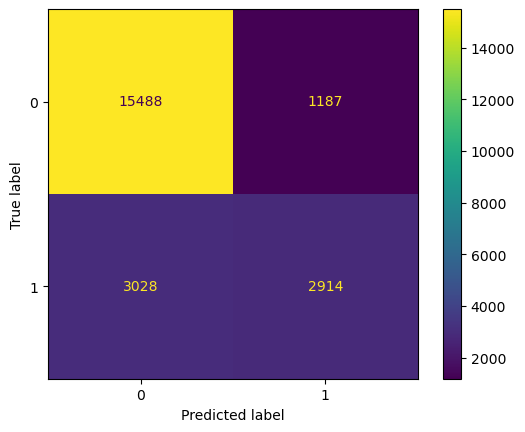

In [23]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_hat)

In [24]:
#finding test accuracy
print("Accuracy: " + str(best_.score(X_test, y_test) * 100) + "%")

Accuracy: 81.36357607109697%


In [25]:
#performing feature selection
selector = SelectKBest(f_classif, k=5)
selector.fit(X_train, y_train)
X_train_select = selector.transform(X_train)
X_test_select = selector.transform(X_test)

In [26]:
#fitting model to selected features
svm_linear_select = SVC(C=1, kernel='linear')
svm_linear_select.fit(X_train_select, y_train)

SVC(C=1, kernel='linear')

In [27]:
#hyperparameter tuning using cross-validation and grid search 
kfold = skm.KFold(5, 
                  random_state=0,
                  shuffle=True)
grid = skm.GridSearchCV(svm_linear_select,
                        {'C':[0.01,0.1,1,10]},
                        refit=True,
                        cv=kfold,
                        scoring='accuracy')
grid.fit(X_train_select, y_train)
grid.best_params_


{'C': 0.1}

In [28]:
grid.cv_results_[('mean_test_score')]


array([0.8103882 , 0.81059666, 0.81053981, 0.81052086])

In [29]:
# fetching the best model and finding confusion matrix for test predictions
best_select = grid.best_estimator_
y_test_hat = best_select.predict(X_test_select)
confusion_table(y_test_hat, y_test)


Truth,0,1
Predicted,,
0,15500,3171
1,1175,2771


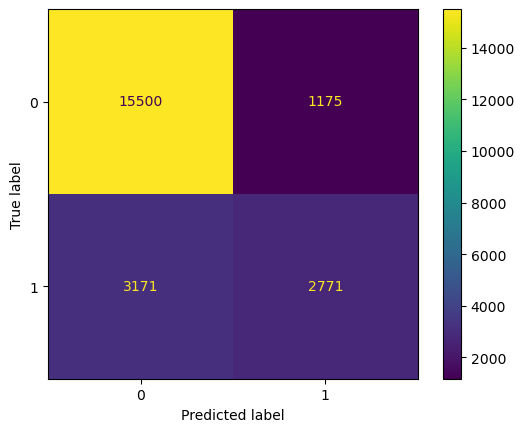

In [30]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_hat)

In [31]:
#finding test accuracy
print("Accuracy: " + str(best_select.score(X_test_select, y_test) * 100) + "%")

Accuracy: 80.784365742583%


Here the model achieved without feature selection has a higher test accuracy than the model acheived with feature selection

In [32]:
#creating dataframe having features and its importances
result = permutation_importance(best_, X_test, y_test, n_repeats=5, random_state=1)
importance_df = pd.DataFrame({'feature': latest_df.drop(columns=['OWNERSHP_2'],axis=1).columns, 'importance': result.importances_mean})
importance_df = importance_df.sort_values(by='importance', ascending=False).reset_index(drop=True)

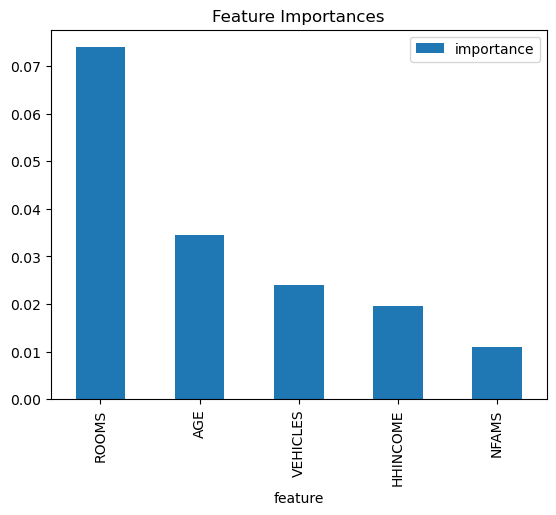

In [33]:
#plotting bar graph for top 5 features and its importance value
importance_df.iloc[:5].plot(kind='bar', x='feature', y='importance')
plt.title('Feature Importances')
plt.show()

In [34]:
# get the top 5 predictor variables
top_predictors = importance_df.head(5)['feature'].values
print("Top 5 predictwor variables:", top_predictors)

Top 5 predictwor variables: ['ROOMS' 'AGE' 'VEHICLES' 'HHINCOME' 'NFAMS']


Text(0.5, 1.0, 'Top 2 Predictor Variables SVM Decision Boundary')

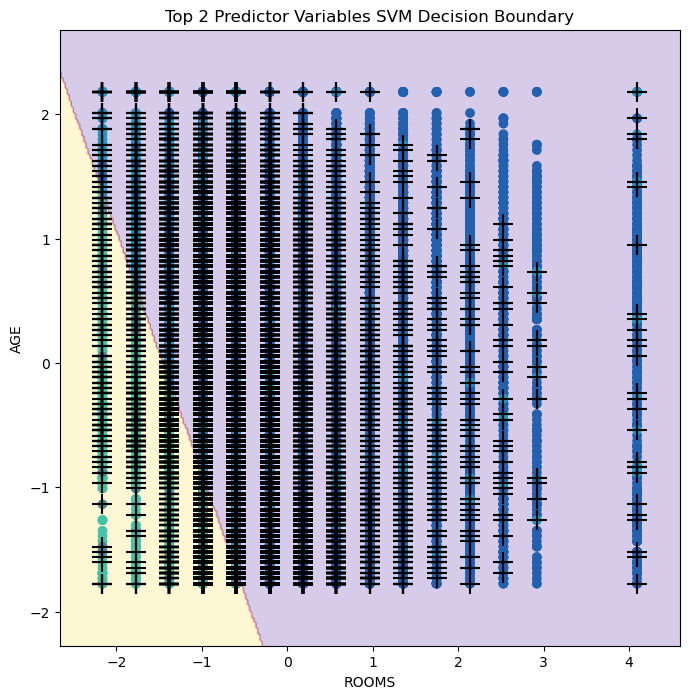

In [35]:
# plot of top 2 Predictor Variables SVM Decision Boundary
fig, ax = subplots(figsize=(8,8))
plot_svm(X_train,
         y_train,
         best_,
         features=(1,4),
         ax=ax)
ax.set_xlabel(top_predictors[0]) 
ax.set_ylabel(top_predictors[1])  
ax.set_title('Top 2 Predictor Variables SVM Decision Boundary')  

### SVC with Polynomial kernel
#### Response variable: OWNERSHP_2

In [36]:
#splitting dataset into train and test sets
(X_train,
 X_test,
 y_train,
 y_test) = skm.train_test_split(latest_df.drop(columns=['OWNERSHP_2'],axis=1),
                                latest_df['OWNERSHP_2'],
                                test_size=0.3,
                                random_state=0)

In [37]:
# Scale train and test sets
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [38]:
#fitting model to training data
svm_poly = SVC(C=0.01,kernel="poly", degree=2)
svm_poly.fit(X_train, y_train)


SVC(C=0.01, degree=2, kernel='poly')

In [39]:
#hyperparameter tuning using cross-validation and grid search 
kfold = skm.KFold(5, 
                  random_state=0,
                  shuffle=True)
grid = skm.GridSearchCV(svm_poly,
                        {'C':[0.01,0.1,1],
                        'degree':[2,3,4]},
                        refit=True,
                        cv=kfold,
                        scoring='accuracy')
grid.fit(X_train, y_train)
grid.best_params_


{'C': 1, 'degree': 3}

In [40]:
# fetching the best model and finding confusion matrix for test predictions
best_ = grid.best_estimator_
y_test_hat = best_.predict(X_test)
confusion_table(y_test_hat, y_test)


Truth,0,1
Predicted,,
0,16147,3988
1,528,1954


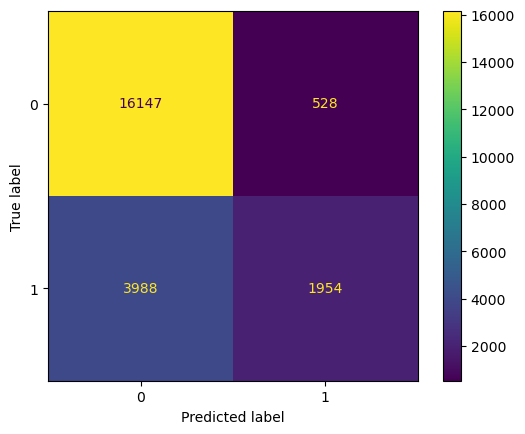

In [41]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_hat)

In [42]:
#finding test accuracy
print("Accuracy: " + str(best_.score(X_test, y_test) * 100) + "%")

Accuracy: 80.03271875138171%


In [43]:
#performing feature selection
selector = SelectKBest(f_classif, k=5)
selector.fit(X_train, y_train)
X_train_select = selector.transform(X_train)
X_test_select = selector.transform(X_test)

In [44]:
#fitting model to selected features
svm_poly_select = SVC(C=0.01,kernel="poly", degree=2)
svm_poly_select.fit(X_train_select, y_train)

SVC(C=0.01, degree=2, kernel='poly')

In [45]:
#hyperparameter tuning using cross-validation and grid search 
kfold = skm.KFold(5, 
                  random_state=0,
                  shuffle=True)
grid = skm.GridSearchCV(svm_poly_select,
                        {'C':[0.01,0.1,1],
                        'degree':[2,3,4]},
                        refit=True,
                        cv=kfold,
                        scoring='accuracy')
grid.fit(X_train_select, y_train)
grid.best_params_


{'C': 1, 'degree': 3}

In [46]:
# fetching the best model and finding confusion matrix for test predictions
best_select = grid.best_estimator_
y_test_hat = best_select.predict(X_test_select)
confusion_table(y_test_hat, y_test)


Truth,0,1
Predicted,,
0,16228,4205
1,447,1737


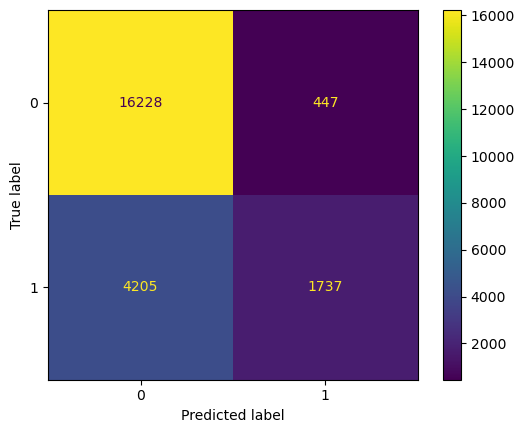

In [47]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_hat)

In [48]:
#finding test accuracy
print("Accuracy: " + str(best_select.score(X_test_select, y_test) * 100) + "%")

Accuracy: 79.43140115842066%


Here the model achieved without feature selection has a higher test accuracy than the model acheived with feature selection

In [49]:
#creating dataframe having features and its importances
result = permutation_importance(best_, X_test, y_test, n_repeats=5, random_state=1)
importance_df = pd.DataFrame({'feature': latest_df.drop(columns=['OWNERSHP_2'],axis=1).columns, 'importance': result.importances_mean})
importance_df = importance_df.sort_values(by='importance', ascending=False).reset_index(drop=True)

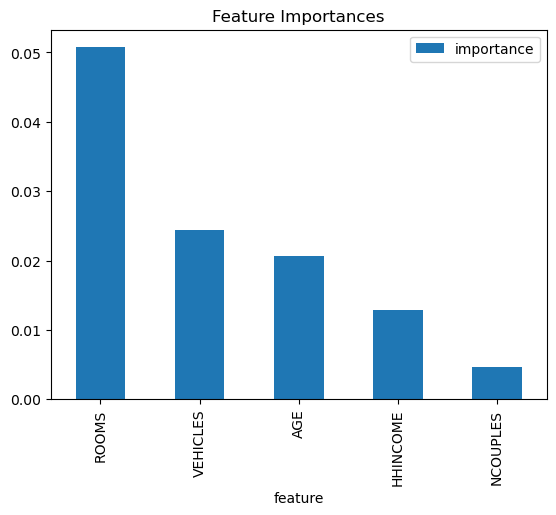

In [50]:
#plotting bar graph for top 5 features and its importance value
importance_df.iloc[:5].plot(kind='bar', x='feature', y='importance')
plt.title('Feature Importances')
plt.show()

In [51]:
# get the top 5 predictor variables
top_predictors = importance_df.head(5)['feature'].values
print("Top 5 predictwor variables:", top_predictors)

Top 5 predictwor variables: ['ROOMS' 'VEHICLES' 'AGE' 'HHINCOME' 'NCOUPLES']


Text(0.5, 1.0, 'Top 2 Predictor Variables SVM Decision Boundary')

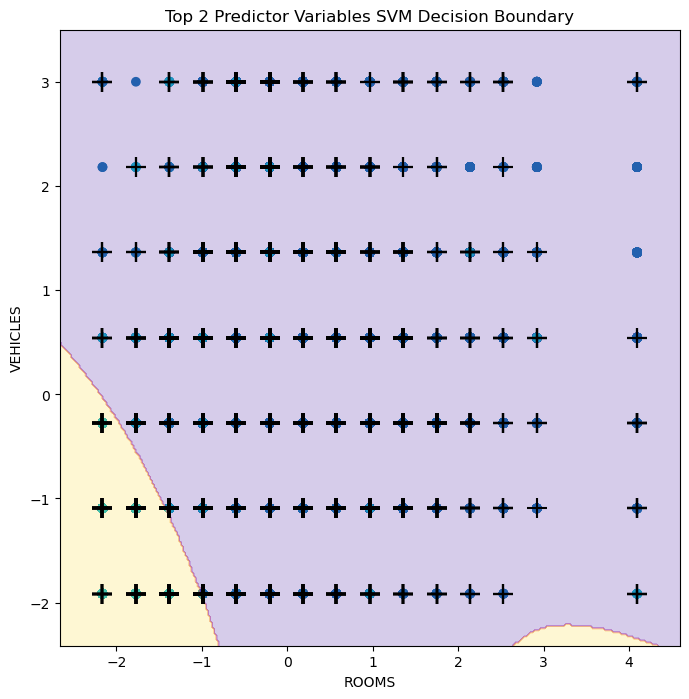

In [53]:
# plot of top 2 Predictor Variables SVM Decision Boundary
fig, ax = subplots(figsize=(8,8))
plot_svm(X_train,
         y_train,
         best_,
         features=(1, 2),
         ax=ax)
ax.set_xlabel(top_predictors[0]) 
ax.set_ylabel(top_predictors[1])  
ax.set_title('Top 2 Predictor Variables SVM Decision Boundary')  

### SVC with Radial kernel
#### Response variable: OWNERSHP_2

In [16]:
#splitting dataset into train and test sets
(X_train,
 X_test,
 y_train,
 y_test) = skm.train_test_split(latest_df.drop(columns=['OWNERSHP_2'],axis=1),
                                latest_df['OWNERSHP_2'],
                                test_size=0.3,
                                random_state=0)

In [33]:
X_test.shape

(22617, 6)

In [17]:
# Scale train and test sets
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [18]:
#fitting model to training data
svm_radial = SVC(kernel="rbf", gamma=1, C=1)
svm_radial.fit(X_train, y_train)


SVC(C=1, gamma=1)

In [19]:
#hyperparameter tuning using cross-validation and grid search 
kfold = skm.KFold(5, 
                  random_state=0,
                  shuffle=True)
grid = skm.GridSearchCV(svm_radial,
                        {'C':[0.01,0.1,1],
                         'gamma':[0.01, 0.1, 1, 10]},
                        refit=True,
                        cv=kfold,
                        scoring='accuracy');
grid.fit(X_train, y_train)
grid.best_params_


{'C': 1, 'gamma': 10}

In [20]:
# fetching the best model and finding confusion matrix for test predictions
best_ = grid.best_estimator_
y_test_hat = best_.predict(X_test)
confusion_table(y_test_hat, y_test)


Truth,0,1
Predicted,,
0,15526,2777
1,1149,3165


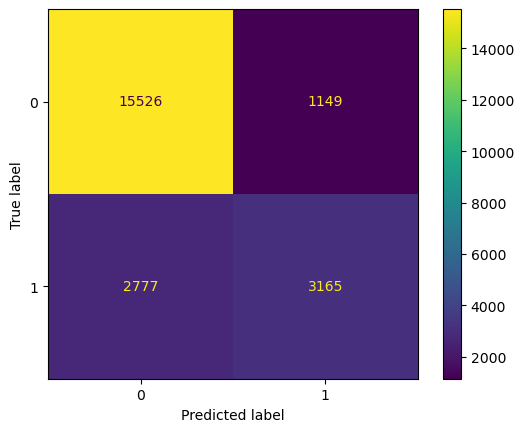

In [21]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_hat)

In [22]:
#finding test accuracy
print("Accuracy: " + str(best_.score(X_test, y_test) * 100) + "%")

Accuracy: 82.64137595613919%


In [23]:
#performing feature selection
selector = SelectKBest(f_classif, k=5)
selector.fit(X_train, y_train)
X_train_select = selector.transform(X_train)
X_test_select = selector.transform(X_test)

In [24]:
#fitting model to selected features
svm_radial_select = SVC(kernel="rbf", gamma=1, C=1)
svm_radial_select.fit(X_train_select, y_train)

SVC(C=1, gamma=1)

In [25]:
#hyperparameter tuning using cross-validation and grid search 
kfold = skm.KFold(5, 
                  random_state=0,
                  shuffle=True)
grid = skm.GridSearchCV(svm_radial_select,
                        {'C':[0.01,0.1,1],
                         'gamma':[0.01, 0.1, 1, 10]},
                        refit=True,
                        cv=kfold,
                        scoring='accuracy');
grid.fit(X_train_select, y_train)
grid.best_params_

{'C': 1, 'gamma': 10}

In [26]:
# fetching the best model and finding confusion matrix for test predictions
best_select = grid.best_estimator_
y_test_hat = best_select.predict(X_test_select)
confusion_table(y_test_hat, y_test)


Truth,0,1
Predicted,,
0,15463,2816
1,1212,3126


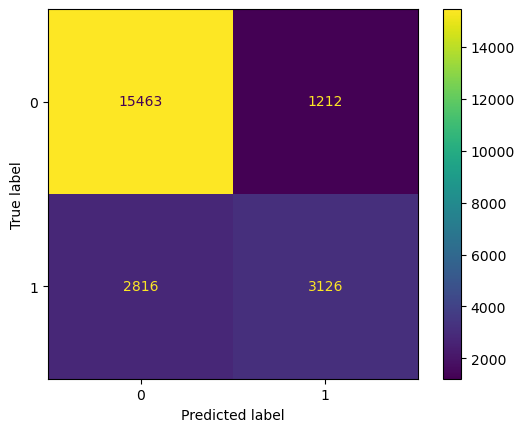

In [27]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_hat)

In [28]:
#finding test accuracy
print("Accuracy: " + str(best_select.score(X_test_select, y_test) * 100) + "%")

Accuracy: 82.1903877614184%


Here the model achieved without feature selection has a higher test accuracy than the model acheived with feature selection

In [29]:
#creating dataframe having features and its importances
result = permutation_importance(best_, X_test, y_test, n_repeats=5, random_state=1)
importance_df = pd.DataFrame({'feature': latest_df.drop(columns=['OWNERSHP_2'],axis=1).columns, 'importance': result.importances_mean})
importance_df = importance_df.sort_values(by='importance', ascending=False).reset_index(drop=True)

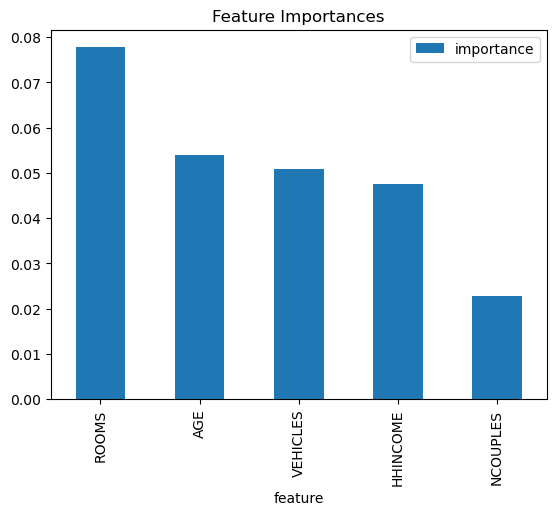

In [30]:
#plotting bar graph for top 5 features and its importance value
importance_df.iloc[:5].plot(kind='bar', x='feature', y='importance')
plt.title('Feature Importances')
plt.show()

In [31]:
# get the top 5 predictor variables
top_predictors = importance_df.head(5)['feature'].values
print("Top 5 predictwor variables:", top_predictors)

Top 5 predictwor variables: ['ROOMS' 'AGE' 'VEHICLES' 'HHINCOME' 'NCOUPLES']


Text(0.5, 1.0, 'Top 2 Predictor Variables SVM Decision Boundary')

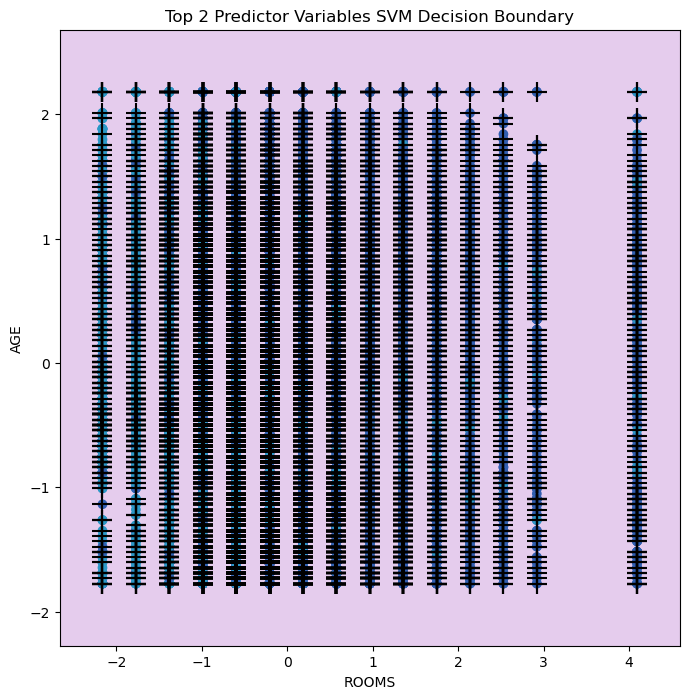

In [32]:
# plot of top 2 Predictor Variables SVM Decision Boundary
fig, ax = subplots(figsize=(8,8))
plot_svm(X_train,
         y_train,
         best_,
         features=(1, 4),
         ax=ax)
ax.set_xlabel(top_predictors[0]) 
ax.set_ylabel(top_predictors[1])  
ax.set_title('Top 2 Predictor Variables SVM Decision Boundary')  